# Books Factor Analysis
The code below calculates additional factors from the dataset and tests their effectiveness in training with Logistic Regression and Random Forest

Factors are:
- ARI (Readability)
- Review Length
- punctuation
- capitalisation
- edit&update
- adjectives

In [1]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import re 
from collections import Counter
from string import punctuation
import textstat # pip install textstat

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

In [2]:
df = pd.read_csv('../Datasets/Modified_Books_rating.csv')
df.head()

,Title,helpful,Rating,Title.1,Review,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews
0,Alaska Sourdough,36/37,5.0,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,97,153,1,ruth allman written excellent book alaskan sou...
1,Alaska Sourdough,29/30,5.0,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,96,63,1,i using book since eighth printing i honestly ...
2,Alaska Sourdough,25/28,5.0,Cheechako to Sourdough in 190 Pages,"My poor dogeared, stained copy of this book ca...",25,28,89,206,1,my poor dogeared stained copy book came way da...
3,Eyewitness Travel Guide to Europe,3/20,1.0,Disappointed Romanian!,This book in my opinion is biased and takes an...,3,20,15,92,0,this book opinion biased take angle europe cle...
4,Eyewitness Travel Guide to Europe,20/20,5.0,Going to Europe? Get this book!,If you're already a fan of the Eyewitness Trav...,20,20,100,234,1,if youre already fan eyewitness travel guide s...


## ARI

In [3]:
def calculate_ari(text):
    ari = textstat.automated_readability_index(text)
    return ari

df['ARI'] = df['Review'].apply(calculate_ari)
df.head()

,Title,helpful,Rating,Title.1,Review,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews,ARI
0,Alaska Sourdough,36/37,5.0,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,97,153,1,ruth allman written excellent book alaskan sou...,8.1
1,Alaska Sourdough,29/30,5.0,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,96,63,1,i using book since eighth printing i honestly ...,5.7
2,Alaska Sourdough,25/28,5.0,Cheechako to Sourdough in 190 Pages,"My poor dogeared, stained copy of this book ca...",25,28,89,206,1,my poor dogeared stained copy book came way da...,7.6
3,Eyewitness Travel Guide to Europe,3/20,1.0,Disappointed Romanian!,This book in my opinion is biased and takes an...,3,20,15,92,0,this book opinion biased take angle europe cle...,10.9
4,Eyewitness Travel Guide to Europe,20/20,5.0,Going to Europe? Get this book!,If you're already a fan of the Eyewitness Trav...,20,20,100,234,1,if youre already fan eyewitness travel guide s...,18.3


In [4]:
# number of reviews with an ARI < 8 (equals 3rd grade level and is very easy to read)
low_ari_reviews = df[df['ARI'] < 8]
num_low_ari_reviews = len(low_ari_reviews)

print(f"Number of Reviews with ARI < 8: {num_low_ari_reviews}")

Number of Reviews with ARI < 8: 41189


In [5]:
def convert_ari(df):
    if df['ARI'] <= 8.0:
        ari = 1 # for readable
    else:
        ari = 0 # for not readable
    return ari

df['IsReadable'] = df.apply(convert_ari, axis=1)
df.head()

,Title,helpful,Rating,Title.1,Review,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews,ARI,IsReadable
0,Alaska Sourdough,36/37,5.0,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,97,153,1,ruth allman written excellent book alaskan sou...,8.1,0
1,Alaska Sourdough,29/30,5.0,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,96,63,1,i using book since eighth printing i honestly ...,5.7,1
2,Alaska Sourdough,25/28,5.0,Cheechako to Sourdough in 190 Pages,"My poor dogeared, stained copy of this book ca...",25,28,89,206,1,my poor dogeared stained copy book came way da...,7.6,1
3,Eyewitness Travel Guide to Europe,3/20,1.0,Disappointed Romanian!,This book in my opinion is biased and takes an...,3,20,15,92,0,this book opinion biased take angle europe cle...,10.9,0
4,Eyewitness Travel Guide to Europe,20/20,5.0,Going to Europe? Get this book!,If you're already a fan of the Eyewitness Trav...,20,20,100,234,1,if youre already fan eyewitness travel guide s...,18.3,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'IsReadable']], df['IsHelpful'], test_size=0.2, random_state=42)

# Replace NaN with an empty string
X_train['cleaned_reviews'].fillna('', inplace=True) 

# feature extraction
vectorizer = TfidfVectorizer(max_features=6000) # ca 10% von Datensatz Phones
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['IsReadable'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['IsReadable'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.7886614862646383
Random Forest Accuracy: 0.7492247637809638

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75     11788
           1       0.81      0.83      0.82     15623

    accuracy                           0.79     27411
   macro avg       0.79      0.78      0.78     27411
weighted avg       0.79      0.79      0.79     27411


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.62      0.68     11788
           1       0.75      0.85      0.79     15623

    accuracy                           0.75     27411
   macro avg       0.75      0.73      0.74     27411
weighted avg       0.75      0.75      0.74     27411



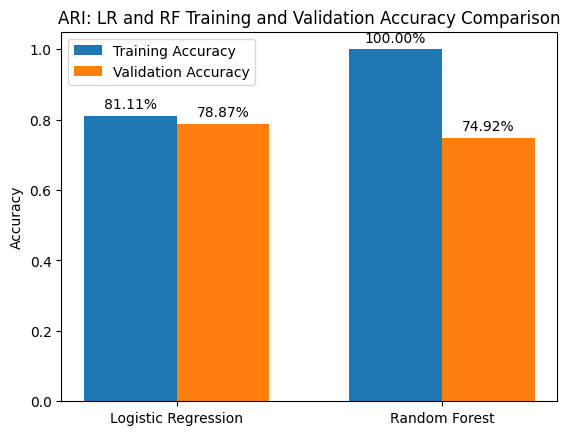

In [7]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]

ari_lr_train_accuracy = lr_train_accuracy
ari_rf_train_accuracy = rf_train_accuracy

ari_lr_test_accuracy = lr_accuracy
ari_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('ARI: LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

## Review Length

In [8]:
# Drop rows with NaN values in 'cleaned_reviews'
df = df.dropna(subset=['cleaned_reviews'])

X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'review_len']], df['IsHelpful'], test_size=0.2, random_state=42)
# feature extraction
vectorizer = TfidfVectorizer(max_features=6000) # ca 10% von Datensatz Phones
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['review_len'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['review_len'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.7896829739885447
Random Forest Accuracy: 0.7505745868446974

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75     11815
           1       0.81      0.83      0.82     15596

    accuracy                           0.79     27411
   macro avg       0.79      0.78      0.78     27411
weighted avg       0.79      0.79      0.79     27411


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.62      0.68     11815
           1       0.75      0.85      0.80     15596

    accuracy                           0.75     27411
   macro avg       0.75      0.73      0.74     27411
weighted avg       0.75      0.75      0.75     27411



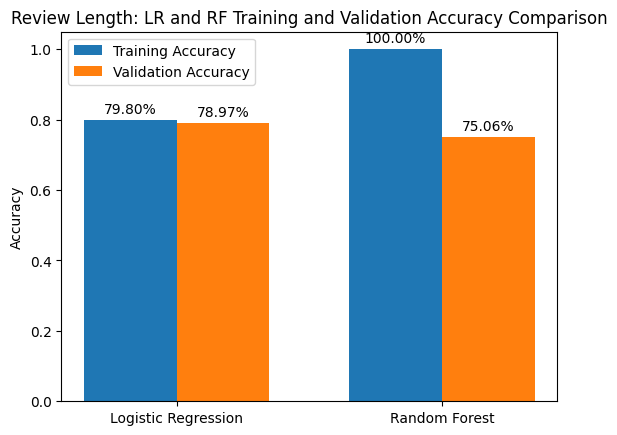

In [9]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]

len_lr_train_accuracy = lr_train_accuracy
len_rf_train_accuracy = rf_train_accuracy

len_lr_test_accuracy = lr_accuracy
len_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Review Length: LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

## Punctuation Marks

In [10]:
# Get punctuation ratio (! and ?)
df['ExclamationMarks_Count'] = df['Review'].str.count('!')
df['QuestionMarks_Count'] = df['Review'].str.count('\?')

# Calculate Ratio/Percent of Punc. Marks relative to review length
df['ExclamationMarks_Ratio'] = df['ExclamationMarks_Count'] / df['review_len']
df['QuestionMarks_Ratio'] = df['QuestionMarks_Count'] / df['review_len']

df['ExclamationMarks_Ratio'] = df['ExclamationMarks_Ratio'].fillna(0)
df['QuestionMarks_Ratio'] = df['QuestionMarks_Ratio'].fillna(0)

df['ExclamationMarks_Percent'] = (df['ExclamationMarks_Ratio'] * 100).astype(int)
df['QuestionMarks_Percent'] = (df['QuestionMarks_Ratio'] * 100).astype(int)

# combine both
df['Sum_punctuationMarks'] = df['ExclamationMarks_Percent'] + df['QuestionMarks_Percent']

# delete unused columns:
df.drop(['ExclamationMarks_Count', 'QuestionMarks_Count','ExclamationMarks_Ratio', 'QuestionMarks_Ratio','ExclamationMarks_Percent', 'QuestionMarks_Percent'], axis='columns', inplace=True)

df.head()

,Title,helpful,Rating,Title.1,Review,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews,ARI,IsReadable,Sum_punctuationMarks
0,Alaska Sourdough,36/37,5.0,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,97,153,1,ruth allman written excellent book alaskan sou...,8.1,0,0
1,Alaska Sourdough,29/30,5.0,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,96,63,1,i using book since eighth printing i honestly ...,5.7,1,1
2,Alaska Sourdough,25/28,5.0,Cheechako to Sourdough in 190 Pages,"My poor dogeared, stained copy of this book ca...",25,28,89,206,1,my poor dogeared stained copy book came way da...,7.6,1,1
3,Eyewitness Travel Guide to Europe,3/20,1.0,Disappointed Romanian!,This book in my opinion is biased and takes an...,3,20,15,92,0,this book opinion biased take angle europe cle...,10.9,0,0
4,Eyewitness Travel Guide to Europe,20/20,5.0,Going to Europe? Get this book!,If you're already a fan of the Eyewitness Trav...,20,20,100,234,1,if youre already fan eyewitness travel guide s...,18.3,0,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'Sum_punctuationMarks']], df['IsHelpful'], test_size=0.2, random_state=42)
# feature extraction
vectorizer = TfidfVectorizer(max_features=6000) # ca 10% von Datensatz Phones
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['Sum_punctuationMarks'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['Sum_punctuationMarks'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.7931487359089416
Random Forest Accuracy: 0.7542592389916457

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75     11815
           1       0.81      0.84      0.82     15596

    accuracy                           0.79     27411
   macro avg       0.79      0.79      0.79     27411
weighted avg       0.79      0.79      0.79     27411


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.62      0.69     11815
           1       0.75      0.85      0.80     15596

    accuracy                           0.75     27411
   macro avg       0.76      0.74      0.74     27411
weighted avg       0.76      0.75      0.75     27411



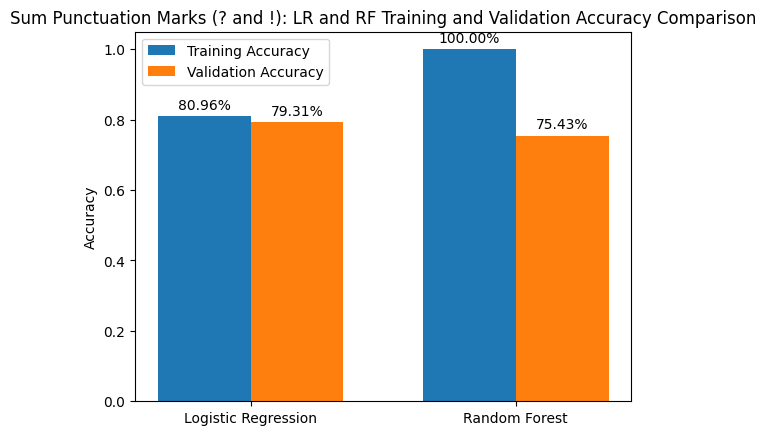

In [12]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]

pct_lr_train_accuracy = lr_train_accuracy
pct_rf_train_accuracy = rf_train_accuracy

pct_lr_test_accuracy = lr_accuracy
pct_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Sum Punctuation Marks (? and !): LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

## Capitalisation

In [13]:
df['Capslock_Count'] = df['Review'].str.findall(r'\b(?![Ii]\b)[A-Z]+\b').str.len()
df['Capslock_Ratio'] = df['Capslock_Count'] / df['review_len']
df['Capslock_Ratio'] = df['Capslock_Ratio'].fillna(0)
df['Capslock_Percent'] = (df['Capslock_Ratio'] * 100).astype(int)
df.drop(['Capslock_Count','Capslock_Ratio'], axis='columns', inplace=True)
df.head()

,Title,helpful,Rating,Title.1,Review,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews,ARI,IsReadable,Sum_punctuationMarks,Capslock_Percent
0,Alaska Sourdough,36/37,5.0,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,97,153,1,ruth allman written excellent book alaskan sou...,8.1,0,0,0
1,Alaska Sourdough,29/30,5.0,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,96,63,1,i using book since eighth printing i honestly ...,5.7,1,1,0
2,Alaska Sourdough,25/28,5.0,Cheechako to Sourdough in 190 Pages,"My poor dogeared, stained copy of this book ca...",25,28,89,206,1,my poor dogeared stained copy book came way da...,7.6,1,1,0
3,Eyewitness Travel Guide to Europe,3/20,1.0,Disappointed Romanian!,This book in my opinion is biased and takes an...,3,20,15,92,0,this book opinion biased take angle europe cle...,10.9,0,0,1
4,Eyewitness Travel Guide to Europe,20/20,5.0,Going to Europe? Get this book!,If you're already a fan of the Eyewitness Trav...,20,20,100,234,1,if youre already fan eyewitness travel guide s...,18.3,0,0,1


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'Capslock_Percent']], df['IsHelpful'], test_size=0.2, random_state=42)
# feature extraction
vectorizer = TfidfVectorizer(max_features=6000) # ca 10% von Datensatz Phones
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['Capslock_Percent'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['Capslock_Percent'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.7921637298894605
Random Forest Accuracy: 0.7553172084199774

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75     11815
           1       0.81      0.83      0.82     15596

    accuracy                           0.79     27411
   macro avg       0.79      0.79      0.79     27411
weighted avg       0.79      0.79      0.79     27411


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.63      0.69     11815
           1       0.75      0.85      0.80     15596

    accuracy                           0.76     27411
   macro avg       0.76      0.74      0.74     27411
weighted avg       0.76      0.76      0.75     27411



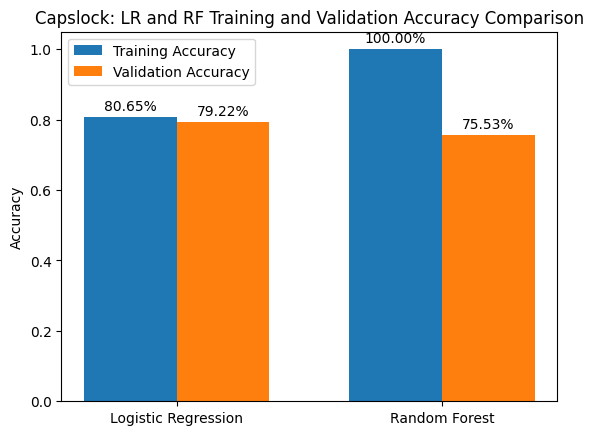

In [15]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]

cap_lr_test_accuracy = lr_accuracy
cap_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Capslock: LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

## Edits&Updates

In [16]:
df['contains_updates'] = df['Review'].str.contains('contains_updates', case=False).astype(int)

X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'contains_updates']], df['IsHelpful'], test_size=0.2, random_state=42)
# feature extraction
vectorizer = TfidfVectorizer(max_features=6000) # ca 10% von Datensatz Phones
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['contains_updates'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['contains_updates'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.7925285469337128
Random Forest Accuracy: 0.7549523913757251

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75     11815
           1       0.81      0.83      0.82     15596

    accuracy                           0.79     27411
   macro avg       0.79      0.79      0.79     27411
weighted avg       0.79      0.79      0.79     27411


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.62      0.69     11815
           1       0.75      0.85      0.80     15596

    accuracy                           0.75     27411
   macro avg       0.76      0.74      0.74     27411
weighted avg       0.76      0.75      0.75     27411



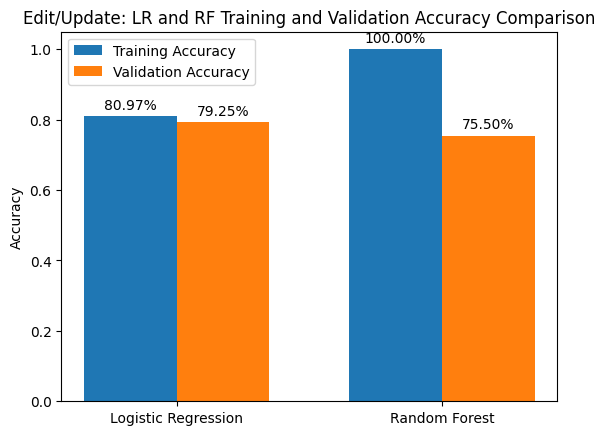

In [17]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]


ed_lr_test_accuracy = lr_accuracy
ed_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Edit/Update: LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

## Compare all results

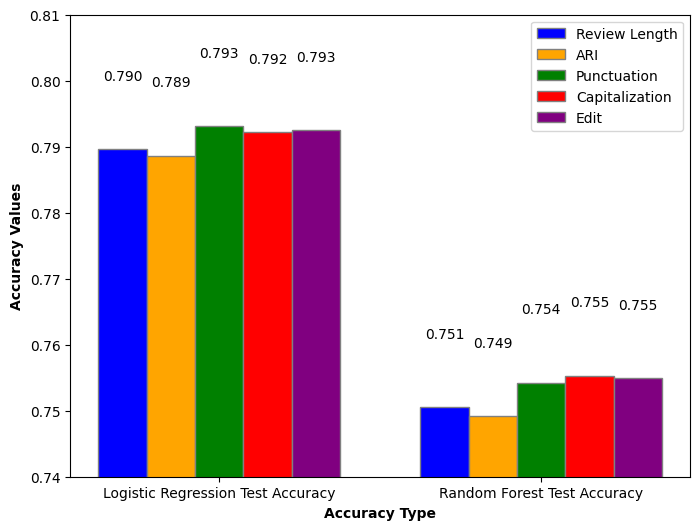

In [31]:
# Labels for the groups
labels = ['Logistic Regression Test Accuracy', 'Random Forest Test Accuracy']

# Width of the bars
bar_width = 0.15

# Extract values for LR Test and RF Test
len_values_subset = [len_lr_test_accuracy, len_rf_test_accuracy]
ari_values_subset = [ari_lr_test_accuracy, ari_rf_test_accuracy]
pct_values_subset = [pct_lr_test_accuracy, pct_rf_test_accuracy]
cap_values_subset = [cap_lr_test_accuracy, cap_rf_test_accuracy]
ed_values_subset = [ed_lr_test_accuracy, ed_rf_test_accuracy]

# Set the positions of bars on X-axis
r1_subset = np.arange(len(labels))
r2_subset = [x + bar_width for x in r1_subset]
r3_subset = [x + bar_width for x in r2_subset]
r4_subset = [x + bar_width for x in r3_subset]
r5_subset = [x + bar_width for x in r4_subset]

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(r1_subset, len_values_subset, color='blue', width=bar_width, edgecolor='grey', label='Review Length')
ax.bar(r2_subset, ari_values_subset, color='orange', width=bar_width, edgecolor='grey', label='ARI')
ax.bar(r3_subset, pct_values_subset, color='green', width=bar_width, edgecolor='grey', label='Punctuation')
ax.bar(r4_subset, cap_values_subset, color='red', width=bar_width, edgecolor='grey', label='Capitalization')
ax.bar(r5_subset, ed_values_subset, color='purple', width=bar_width, edgecolor='grey', label='Edit')

# Adding labels
plt.xlabel('Accuracy Type', fontweight='bold')
plt.ylabel('Accuracy Values', fontweight='bold')
ax.set_xticks([r + 2*bar_width for r in range(len(labels))])
ax.set_xticklabels(labels)

# Adding legend
ax.legend()

# Adding values above the bars
for r, values in zip([r1_subset, r2_subset, r3_subset, r4_subset, r5_subset], [len_values_subset, ari_values_subset, pct_values_subset, cap_values_subset, ed_values_subset]):
    for i, value in enumerate(values):
        ax.text(r[i], value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Set the y-axis limit between 0.6 and 0.7
ax.set_ylim(0.74, 0.81)

# Display the plot
plt.show()